In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Prepare Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import trefide.preprocess as preprocess
import scipy.io as io

Simulations run using a cohort 37 real neural signals extracted from a Q-State Bio Voltage Imaging Video (sampled at 1000Hz) as atoms to construct "artificial" signals of arbitrary length. An important assumption is that all neural signals are detrended and centered, so we use a robust B-spline regression informed by the timing of optogenetic stimuli to precisely cut out any slow trends.

In [3]:
# Load Data
stim = io.loadmat("../data/sampleMovie.mat")['stimulationSignal'][1:-50].squeeze()
data = io.loadmat("../data/post_demix.mat")
N, T = data['C'].shape
signals = data['C']

In [4]:
signals, trends, stim, disc_idx = preprocess.detrend(signals, stim, disc_idx=np.array([5]))

In [5]:
T = len(stim)
idx = np.random.randint(0, N)
signal = signals[idx,:]

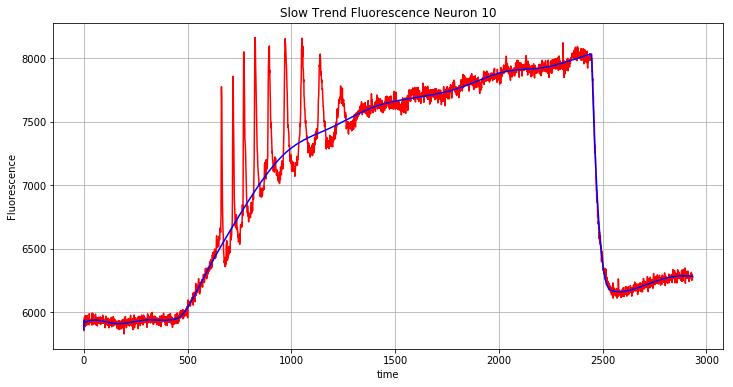

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(T), signal+trends[idx,:], 'r')
ax.plot(np.arange(T), trends[idx,:], 'b')

ax.set(xlabel='time', ylabel='Fluorescence',
       title='Slow Trend Fluorescence Neuron {}'.format(idx))
ax.grid()

plt.show()

# Compare Solve Times Over Range of Problem Sizes

In [7]:
from trefide.solvers.temporal import cps_cadmm, cpdas, cps_cpdas,\
                                     ladmm, lpdas, lipm
from trefide.utils import psd_noise_estimate
from timeit import timeit

## Run Simulations

In [8]:
sizeData = np.arange(1,11) * T
tol = 2e-2

# -------------- No WS Lagrangian Times ----------------
lipm_times = np.zeros((len(signals), len(sizeData)))
lpdas_times = np.zeros((len(signals), len(sizeData)))
ladmm_times = np.zeros((len(signals), len(sizeData)))

# -------------- No WS Constrained Times ----------------
cpdas_times = np.zeros((len(signals), len(sizeData)))
cps_cpdas_times = np.zeros((len(signals), len(sizeData)))
cps_cadmm_times = np.zeros((len(signals), len(sizeData)))

# -------------- WS Lagrangian Times ----------------
lpdas_ws_times = np.zeros((len(signals), len(sizeData)))
ladmm_ws_times = np.zeros((len(signals), len(sizeData)))

# -------------- No WS Constrained Times ----------------
cpdas_ws_times = np.zeros((len(signals), len(sizeData)))
cps_cpdas_ws_times = np.zeros((len(signals), len(sizeData)))
cps_cadmm_ws_times = np.zeros((len(signals), len(sizeData)))

# -------------- Run Timed Simulations ----------------
for sdx, signal in enumerate(signals):
    for ndx in np.arange(1,len(sizeData)+1):
        target = np.tile(signal, ndx)
        delta = psd_noise_estimate(target[None,:])[0]
        _, _, lam, _ = cpdas(target, delta)
        
        # -------------- No WS Lagrangian Solvers ----------------
        
        # Lagrangian Interior Point Method
        def time_lipm():
            _, _, _ = lipm(target, lam)
        lipm_times[sdx, ndx-1] += timeit(time_lipm, number=1)
        
        # Langrangian Primal-Dual Active Set Method
        def time_lpdas():
            _, _, _ = lpdas(target, lam)
        lpdas_times[sdx, ndx-1] += timeit(time_lpdas, number=1)
        
        # Langrangian Primal-Dual Active Set Method
        def time_ladmm():
            _, _, _ = ladmm(target, lam)
        ladmm_times[sdx, ndx-1] += timeit(time_ladmm, number=1)
        
        # -------------- No WS Constrained Solvers ----------------
        
        # My LS Constrianed Primal-Dual Active Set Method
        def time_cpdas():
            _, _, _, _ = cpdas(target, delta, tol=tol)
        cpdas_times[sdx, ndx-1] += timeit(time_cpdas, number=1)
        
        # CPS LS Constrianed Primal-Dual Active Set Method
        def time_cps_cpdas():
            _, _, _, _ = cps_cpdas(target, delta, tol=tol)
        cps_cpdas_times[sdx, ndx-1] += timeit(time_cps_cpdas, number=1)
        
        # My LS Constrianed Primal-Dual Active Set Method
        def time_cps_cadmm():
            _, _, _, _ = cps_cadmm(target, delta, tol=tol)
        cps_cadmm_times[sdx, ndx-1] += timeit(time_cps_cadmm, number=1)
        
        # -------------- WS Lagrangian Solvers ----------------
        
        # Warm-Started Langrangian Primal-Dual Active Set Method
        _, z_warm_start, _ = lpdas(target, lam*1.1)
        def time_ws_lpdas():
            _, _, _ = lpdas(target, lam, z_hat=z_warm_start)
        lpdas_ws_times[sdx, ndx-1] = timeit(time_ws_lpdas, number=1)
        
        # Warm-Started Langrangian ADMM
        beta_warm_start, alpha_warm_start, u_warm_start = ladmm(target, lam*1.1)
        def time_ws_ladmm():
            _, _, _ = ladmm(target, lam, beta=beta_warm_start, alpha=alpha_warm_start, u=u_warm_start)
        ladmm_ws_times[sdx, ndx-1] = timeit(time_ws_ladmm, number=1)
        
        # -------------- WS Constrained Solvers ----------------
            
        # Warm Started Constrained Primal-Dual Active Set Method
        _, z_warm_start, _ = lpdas(target, lam*1.1)
        def time_ws_cpdas():
            _, _, _, _ = cpdas(target, delta, z_hat=z_warm_start, lambda_=lam*1.1, tol=tol)
        cpdas_ws_times[sdx, ndx-1] = timeit(time_ws_cpdas, number=1)
        
        # Warm Started Constrained Primal-Dual Active Set Method
        _, z_warm_start, _ = lpdas(target, lam*1.1)
        def time_ws_cps_cpdas():
            _, _, _, _ = cps_cpdas(target, delta, z_hat=z_warm_start, lambda_=lam*1.1, tol=tol)
        cps_cpdas_ws_times[sdx, ndx-1] = timeit(time_ws_cps_cpdas, number=1)
        
        # Warm Started Constrained Primal-Dual Active Set Method
        beta_warm_start, alpha_warm_Start, u_warm_start = ladmm(target, lam*1.1)
        def time_ws_cps_cadmm():
            _, _, _, _ = cps_cadmm(target, delta, beta=beta_warm_start, alpha=alpha_warm_start, u=u_warm_start, lambda_=lam*1.1, tol=tol)
        cps_cadmm_ws_times[sdx, ndx-1] = timeit(time_ws_cps_cadmm, number=1)

### Compare Results

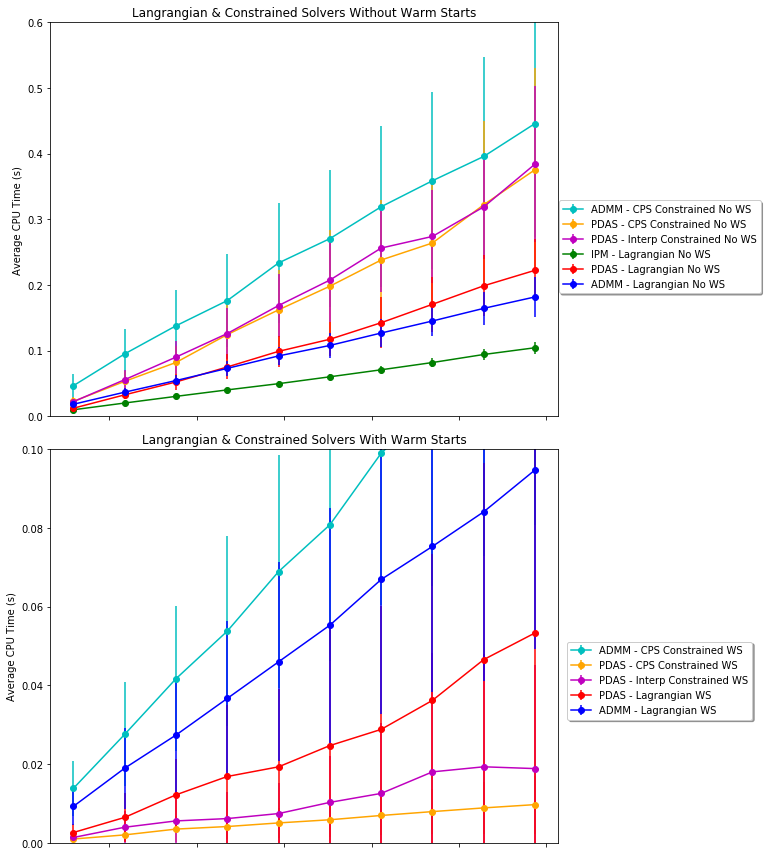

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,12), sharex=False)

ax = axs[0]
ax.errorbar(sizeData, np.mean(cps_cadmm_times, axis=0), yerr=np.std(cps_cadmm_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(cps_cpdas_times, axis=0), yerr=np.std(cps_cpdas_times, axis=0), marker='o', c='orange')
ax.errorbar(sizeData, np.mean(cpdas_times, axis=0), yerr=np.std(cpdas_times, axis=0), marker='o', c='m')
ax.errorbar(sizeData, np.mean(lipm_times, axis=0), yerr=np.std(lipm_times, axis=0), marker='o', c='g')
ax.errorbar(sizeData, np.mean(lpdas_times, axis=0), yerr=np.std(lpdas_times, axis=0), marker='o', c='r')
ax.errorbar(sizeData, np.mean(ladmm_times, axis=0), yerr=np.std(ladmm_times, axis=0), marker='o', c='b')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.6))
ax.set_title('Langrangian & Constrained Solvers Without Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['ADMM - CPS Constrained No WS',
           'PDAS - CPS Constrained No WS',
           'PDAS - Interp Constrained No WS',
           'IPM - Lagrangian No WS',
           'PDAS - Lagrangian No WS',
           'ADMM - Lagrangian No WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

ax = axs[1]
ax.errorbar(sizeData, np.mean(cps_cadmm_ws_times, axis=0), yerr=np.std(cps_cadmm_ws_times, axis=0), marker='o', c='c')
ax.errorbar(sizeData, np.mean(cps_cpdas_ws_times, axis=0), yerr=np.std(cps_cpdas_ws_times, axis=0), marker='o', c='orange')
ax.errorbar(sizeData, np.mean(cpdas_ws_times, axis=0), yerr=np.std(cpdas_ws_times, axis=0), marker='o', c='m')
ax.errorbar(sizeData, np.mean(lpdas_ws_times, axis=0), yerr=np.std(lpdas_ws_times, axis=0), marker='o', c='r')
ax.errorbar(sizeData, np.mean(ladmm_ws_times, axis=0), yerr=np.std(ladmm_ws_times, axis=0), marker='o', c='b')
#ax.set_xlabel('Data Length (T)')
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,.1))
ax.set_title('Langrangian & Constrained Solvers With Warm Starts')
plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=6)
ax.legend(['ADMM - CPS Constrained WS',
           'PDAS - CPS Constrained WS',
           'PDAS - Interp Constrained WS',
           'PDAS - Lagrangian WS',
           'ADMM - Lagrangian WS'], 
          loc='lower center', 
          bbox_to_anchor=(1.2, .3),
          ncol=1,
          fancybox=True,
          shadow=True)

plt.tight_layout()
plt.show()

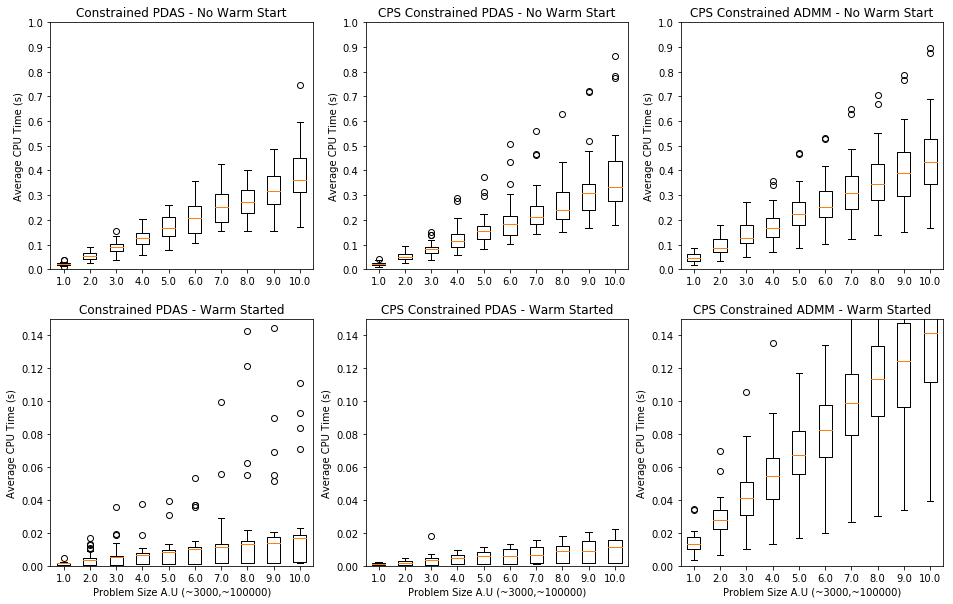

In [10]:
# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,10), sharex=False)
ax = axs[0,0]
ax.boxplot(cpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('Constrained PDAS - No Warm Start')

ax = axs[0,1]
ax.boxplot(cps_cpdas_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('CPS Constrained PDAS - No Warm Start')

ax = axs[1,1]
ax.boxplot(cps_cpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.15))
ax.set_title('CPS Constrained PDAS - Warm Started')

ax = axs[1,0]
ax.boxplot(cpdas_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.15))
ax.set_title('Constrained PDAS - Warm Started')

ax = axs[0,2]
ax.boxplot(cps_cadmm_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_ylim((0,1))
ax.set_title('CPS Constrained ADMM - No Warm Start')

ax = axs[1,2]
ax.boxplot(cps_cadmm_ws_times, positions=sizeData/T)
#plt.setp(ax.get_xticklabels(), visible=False)
ax.locator_params(nbins=11)
ax.set_ylabel('Average CPU Time (s)')
ax.set_xlabel('Problem Size A.U (~3000,~100000)')
ax.set_ylim((0,.15))
ax.set_title('CPS Constrained ADMM - Warm Started')

#fig.tight_layout()
plt.show()

## Record System Information

Sources compiled against single-threaded MKL libraries.

In [11]:
!uname -a

Linux ubuntu-tower 4.10.0-42-generic #46~16.04.1-Ubuntu SMP Mon Dec 4 15:57:59 UTC 2017 x86_64 x86_64 x86_64 GNU/Linux


In [12]:
!cpuinfo

Intel(R) processor family information utility, Version 2018 Update 2 Build 20180125 (id: 18157)
Copyright (C) 2005-2018 Intel Corporation.  All rights reserved.

=====  Processor composition  =====
Processor name    : Intel(R) Xeon(R)  E5-2620 v4 
Packages(sockets) : 1
Cores             : 8
Processors(CPUs)  : 16
Cores per package : 8
Threads per core  : 2

=====  Processor identification  =====
Processor	Thread Id.	Core Id.	Package Id.
0       	0   		0   		0   
1       	0   		1   		0   
2       	0   		2   		0   
3       	0   		3   		0   
4       	0   		4   		0   
5       	0   		5   		0   
6       	0   		6   		0   
7       	0   		7   		0   
8       	1   		0   		0   
9       	1   		1   		0   
10      	1   		2   		0   
11      	1   		3   		0   
12      	1   		4   		0   
13      	1   		5   		0   
14      	1   		6   		0   
15      	1   		7   		0   
=====  Placement on packages  =====
Package Id.	Core Id.	Processors
0   		0,1,2,3,4,5,6,7		(0,8)(1,9)(2,10)(3,11)(4,12)(5,13)(6,14)(7,15)

====